In [6]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from scipy import fftpack
import math
from collections import defaultdict
from heapq import heappush, heappop, heapify

In [7]:
def split(matrix, num):
    sections = []
    for i in range(0, matrix.shape[0], num):
        for j in range(0, matrix.shape[1], num):
            section = matrix[i:i+num, j:j+num]
            sections.append(section)

    return sections


def get_2d_idct(coefficients):
    """ Get 2D Inverse Cosine Transform of Image
    """
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')
        

In [8]:
img = cv2.imread("landscape_resized.jpg")
img_width = img.shape[1]
img_height = img.shape[0]
len(img[0])

1233

## Compressor de Imagens
O método utilizado nesse trabalho seguirá as diretrizes do método JPEG para imagens cromáticas (com cores). Será um método com perdas. Esse método pode ser dividido em 5 etapas:
1. Conversão do espaço de cores
2. Downsampling da chrominance
3. Aplicação da DCT
4. Quantização
5. Codificação de Símbolos utilzando Huffman


### Conversão do Espaço de Cores
Cada pixel de uma imagem colorida é dividida em 3 valores: R(red), G(green), B(blue). No método JPEG, esses valores são convertidos para Y(Luminance) Cb(blue chrominance) Cr(red chrominance). Isso é feito pois o olho humano é capaz de detectar brilho e luminâcia melhor do que detectar cores. Ao separar as cores desse modo, podemos, no próximo passo (Chrominance Downsampling) descartar algumas informações de Cb e Cr, de forma a já diminuir o tamanho necessário para cada pixel enquanto mantemos Y(que se refere ao brilho) intacto. Nesse caso, exploramos a redundânica psicovisual ao remover informações que não são facilmente detectadas, e mantendo aquelas que conseguimos perceber melhor.

In [9]:
def convertRGBToYCbCr(imgInRGB):
    YCbCr_img = cv2.cvtColor(imgInRGB, cv2.COLOR_RGB2YCrCb)
    #plt.imshow(YCbCr_img)
    #print(YCbCr_img)
    Y, Cr, Cb = cv2.split(YCbCr_img)
    return Y, Cb, Cr

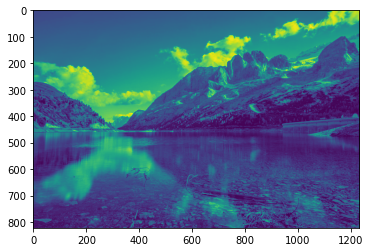

In [10]:
_Y, _Cb, _Cr = convertRGBToYCbCr(img)
plt.imshow(_Y)
#print(_Y)


### Chrominance Downsampling
Para realizar o downsampling, vamos pegar as matrizes referentes à Cb e Cr e então dividi-las em blocos de 2x2 pixels. Para cada bloco, fazemos a média dos valores dos 4 pixels, e então substituimos o bloco inteiro por apenas o valor calculado. Eliminamos, assim, grande parte da informação que nossos olhos mal conseguem perceber. Repare que desse modo diminuimos as matrizes Cb e Cr em 1/4 da imagem da original. Porém, mantivemos a matriz Y no seu tamanho original, que possui os valores relacionados ao brilho e luminânica.

In [11]:
def downsamplingChrominance(chrominanceMatrix):
    pixelSections = split(chrominanceMatrix, 2)

    new_matrix = np.zeros((math.ceil(img_height/2), math.ceil(img_width/2)))
    print(new_matrix.shape)
    counter = 0

    for i in range(0, math.ceil(img_height/2)):
        for j in range(0, math.ceil(img_width/2)):
            pixelSection = pixelSections[counter]
            new_matrix[i][j] = int(round(pixelSection.sum() / 4))
            counter += 1

    return new_matrix

In [12]:
Cb = downsamplingChrominance(_Cb)
Cr = downsamplingChrominance(_Cr)
len(Cb)

(411, 617)
(411, 617)


411

### Aplicação da DCT (Discrete Cosine Transform)
Nessa e na próxima etapa exploramos a característica do olho humano de não ser tão bom em distinguir elementos de alta frequência em uma imagem. Para cada seção da imagem, são "detectadas" regiões de alta frequência de luminância ou chrominance, que então podem ser descartados. Vamos às etapas do processo da aplicação da DCT.

- Para começar, dividimos a imagem em secções de 8x8 pixels.
- Então, diminuimos cada valor em 128 (o intervalo se torna (-128, +128)). -128 é preto enquanto que +128 é branco.
- Então, aplicamos a DCT em todas as secções 8x8 nas 3 matrizes Y, Cb e Cr.

Agora, temos todos os valores das três matrizes baseadas nas constantes definidas na DCT. Repare que ainda não realizamos nenhuma compressão.

In [13]:
def getImageSections(colorMatrix):
    return split(colorMatrix, 8)

def decreasePixelsValues(pixelSection):
    return pixelSection - 128

def runDCT(pixelSection):
    """ Get 2D Cosine Transform of Image """
    return fftpack.dct(fftpack.dct(pixelSection.T, norm='ortho').T, norm='ortho')

def applyDCT(colorMatrix):
    pixelSections = getImageSections(colorMatrix)
    if len(pixelSections) > 30000:
        print(pixelSections[30000])
    dctSections = []
    
    for pixelSection in pixelSections:
        decreased = decreasePixelsValues(pixelSection)
        dct = runDCT(decreased)
        dctSections.append(dct)

    return dctSections


In [14]:
_Y = _Y.astype(int)
Y_dct_sections = applyDCT(_Y)
Cb_dct_sections = applyDCT(Cb)
Cr_dct_sections = applyDCT(Cr)
len(Cr_dct_sections)

4056

### Quantização
Para então realizar a compreensão, passamos por cada bloco de 8x8 pixels e dividimos os valores (que já estão baseados nas constantes da DCT) pelos valores correspondes da tabela de quantização. A tabela de quantização possui valores mais altos no canto inferior direito( que correspondem as posições que possuem maior frequêcia na seção 8x8 de pixels). E então, arredondamos esses valores calculados para o inteiro mais próximo. Percebemos que muitos se tornam zeros, em especial, aqueles que possuem alta frequência. Portanto, estamos descartando dados da imagem original. Porém, são dados que nossos olhos mal conseguem notar. 

Podemos ter tabelas de quantização diferentes para a matriz Y e as matrizes Cb e Cr. Isso porque desejamos manter mais informções da matrix Y, então utilizamos valores menores na tabela de quantização. 

É nessa etapa também que é possível controlar o nível de compressão, com valores mais altos na tabela de quantização comprimindo mais a imagem, enquanto que valores menores mantém a imagem menos alterada.

In [15]:
Y_TABLE = np.array([[8, 6, 5, 8, 12, 20, 26, 31], 
                [6, 6, 7, 10, 13, 29, 30, 28],
                [7, 7, 8, 12, 20, 29, 35, 28],
                [7, 9, 11, 15, 25, 44, 40, 31],
                [9, 11, 19, 28, 34, 55, 52, 39],
                [12, 18, 28, 32, 41, 52, 57, 46],
                [25, 32, 39, 44, 52, 61, 60, 51],
                [36, 46, 48, 49, 56, 50, 52, 50]])


CHR_TABLE = np.array([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

Y_TABLE_2 = np.array([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

CHR_TABLE_2 = np.array([[17, 18, 24, 47, 99, 99, 99, 99], 
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])

def divide(pixelSection, table):
    for i in range (0, pixelSection.shape[1]):
        for j in range (0, pixelSection.shape[0]):
            pixelSection[i][j] /= table[i][j]

def runQuantization(pixelSections, table):
    qnt_sections = []
    for pixelSection in pixelSections:
        divided = np.divide(pixelSection, table[0:pixelSection.shape[0], 0:pixelSection.shape[1]])
        qnt_matrix = divided.round()
        qnt_sections.append(qnt_matrix)

    return qnt_sections

In [16]:
Y_qnt_sections = runQuantization(Y_dct_sections, Y_TABLE_2)
Cb_qnt_sections = runQuantization(Cb_dct_sections, CHR_TABLE_2)
Cr_qnt_sections = runQuantization(Cr_dct_sections, CHR_TABLE_2)

print(len(Y_qnt_sections))



15965


### Codificação de Símbolos
Basta agora codificar de uma forma mais "esperta" e suscinta os valores de cada pixel da imagem. Para cada seção de pixels, iteramos em forma de zigue zague (pois é mais provável que valores não nulos estejam no canto superior esquerdo da seção) e então aplicamos um algoritmo de "comprimento", que vai substituir os valores iguais por apenas um deles e o número de ocorrências. Depois, aplicamos a codificação de Huffman para gerar um código baseado na probabilidade de cada um dos valores. 

In [17]:
def encodeH(symb2freq):
    """Huffman encode the given dict mapping symbols to weights"""
    heap = [[wt, [sym, ""]] for sym, wt in symb2freq.items()]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))

symb2freq = defaultdict(float)
interval = (-255, 255)
interval_size = 510
low_prob = 0.05 / interval_size
med_prob = 0.15 / 6
high_prob = 0.8 / 5

for i in range(interval[0], interval[1]+1):
    symb2freq[str(i)] = low_prob

print(low_prob)

symb2freq['-1'] = high_prob
symb2freq['0'] = high_prob
symb2freq['1'] = high_prob
symb2freq[' '] = high_prob
symb2freq['\n'] = high_prob

symb2freq['-4'] = med_prob
symb2freq['-3'] = med_prob
symb2freq['-2'] = med_prob
symb2freq['2'] = med_prob
symb2freq['3'] = med_prob
symb2freq['4'] = med_prob

sym2codesList = encodeH(symb2freq)
sym2codes = defaultdict(str)

for p in sym2codesList:
    if (symb2freq[p[0]] > 0):
        sym2codes[p[0]] = p[1]


def zigZag(matrix, rows, columns):
    solution=[[] for i in range(rows+columns-1)]
    for i in range(rows):
        for j in range(columns):
            sum=i+j
            if(sum%2 ==0):
                solution[sum].insert(0,matrix[i][j])
            else:
                solution[sum].append(matrix[i][j])

    return np.concatenate(solution, axis = 0)

def shrink(sectionAsArray):
    final = []
    previous = sectionAsArray[0]
    counter = 0
    for elem in sectionAsArray:
        if elem == previous:
            counter += 1
        else:
            final.append(str(int(previous)))
            final.append(str(int(counter)))
            previous = elem
            counter = 1
    
    final.append(str(int(previous)))
    final.append(str(int(counter)))
    
    return final


def runLengthAlgorithm(pixelSection):
    zz = zigZag(pixelSection, pixelSection.shape[0], pixelSection.shape[1])
    return shrink(zz)

def runHuffmanEncoding(lengthRes):
    pass

def encodeQntSections(qnts_sections):
    finalString = ''
    for qnt_section in qnts_sections:
        lengthRes = runLengthAlgorithm(qnt_section)
        lenghStr = ''
        for elem in lengthRes:
            lenghStr = lenghStr + sym2codes[str(elem)] + sym2codes[" "]
        
        finalString = finalString + lenghStr + sym2codes['\n']
    
    #huffmanRes = runHuffmanEncoding(lengthRes)

    return finalString

9.803921568627452e-05


In [18]:
Y_encoded = encodeQntSections(Y_qnt_sections)
Cb_encoded = encodeQntSections(Cb_qnt_sections)
Cr_encoded = encodeQntSections(Cr_qnt_sections)

Pronto! Agora a imagem está codificada. Um exemplo de seção de 8x8 pixels pode ser visualizada abaixo.

In [19]:
def _to_Bytes(data):
  b = bytearray()
  for i in range(0, len(data), 8):
    b.append(int(data[i:i+8], 2))
  return bytes(b)


coded_width = ''
for s in str(img_width):
    coded_width = coded_width + sym2codes[s]

coded_height = ''
for s in str(img_height):
    coded_height = coded_height + sym2codes[s]

header = coded_width + sym2codes[" "] + coded_height + sym2codes["\n"]
final_str = header + Y_encoded + Cb_encoded + Cr_encoded
final_bytes = _to_Bytes(final_str)


with open("my_awesome_img.lpeg", 'wb') as f:
    f.write(_to_Bytes(final_str))

# file = open("my_awesome_img.lpeg", "w")
# file.write(header + Y_encoded + Cb_encoded + Cr_encoded)
# file.close()

### Descomprimindo a Imagem
O processo de descompressão é simples, basta realizar o processo de compressão na ordem inversa. As etapas estão listadas a seguir:
1. Lemos o arquivo comprimido, e então separamos as secções de pixels referentes a cada matrix Y, Cb e Cr.

In [20]:
def decodeFromHuffman(bin_str):
    decoded = ''

    sym2codes_keys = list(sym2codes.keys())
    sym2codes_values = list(sym2codes.values())

    curr = bin_str[0]
    for i in range(1, len(bin_str)):
        if curr not in sym2codes.values():
            curr = curr + bin_str[i]
        
        else:
            position = sym2codes_values.index(curr)
            decoded = decoded + sym2codes_keys[position]
            # if i == len(bin_str) - 1:
            #     break
                
            curr = bin_str[i]

    return decoded.split('\n')

# f = open('my_awesome_img.lpeg', 'rb')
# rawdata = f.read()
# bin_str = ''
# for b in rawdata:
#     bin_str = bin_str + '{0:08b}'.format(b)

# decodedFromHuffman = decodeFromHuffman(bin_str)

In [21]:
def readFileAndGetPixelSections(filename):
    f = open(filename, 'rb')
    rawdata = f.read()
    bin_str = ''
    for b in rawdata:
        bin_str = bin_str + '{0:08b}'.format(b)
    
    lines = decodeFromHuffman(bin_str)
    print(lines[len(lines) - 10 :len(lines)])

    header = lines[0].split()
    
    img_width = int(header[0]) 
    img_height = int(header[1])
    Y_pixelSections = []
    Cb_pixelSections = []
    Cr_pixelSections = []

    Y_lines_num = math.ceil(img_width/8) * math.ceil(img_height/8)
    
    Cb_Cr_width = math.ceil(img_width/2)
    Cb_Cr_height = math.ceil(img_height/2)

    Cb_Cr_lines_num = math.ceil(Cb_Cr_width/8) * math.ceil(Cb_Cr_height/8)

    counter = 1
    for line in lines[1:]:
        res = line.split()
        if counter <= Y_lines_num:
            Y_pixelSections.append(res)
            counter += 1
            continue
        
        if counter > Y_lines_num and counter <= Y_lines_num + Cb_Cr_lines_num:
            Cb_pixelSections.append(res)
            counter += 1
            continue
        
        Cr_pixelSections.append(res)
        counter += 1

    return img_width, img_height, Y_pixelSections, Cb_pixelSections, Cr_pixelSections
        
        
        

In [22]:
img_width, img_height, Y_pixelSections, Cb_pixelSections, Cr_pixelSections = readFileAndGetPixelSections("my_awesome_img.lpeg")
print(img_width)
print(img_height)
print(len(Y_pixelSections))
print(len(Cb_pixelSections))
print(len(Cr_pixelSections))

['2 1 1 1 0 22 ', '1 1 0 3 -1 1 0 19 ', '1 1 0 3 1 1 0 19 ', '0 3 1 1 -1 1 1 1 0 18 ', '-1 2 0 22 ', '-1 1 0 23 ', '-1 1 0 23 ', '-1 1 0 23 ', '-7 1 0 2 ', '11']
1233
822
15965
4056
4057


In [23]:
Cr_pixelSections = Cr_pixelSections[:len(Cr_pixelSections)-1]

2. Para cada secção, decodificamos utilizando o decodificador de huffman.

3. Então, reconstruimos a matriz 8x8 de acordo com a decodificação do algoritmo de comprimento.

In [24]:
def expand(pixelSectionLength):
    final = []
    for i in range(0, len(pixelSectionLength), 2):
        for j in range(0, int(pixelSectionLength[i+1])):
            final.append(int(pixelSectionLength[i]))

    return final


def getPixelSectionMatrix(pixelSectionLength, shape):
    expanded = expand(pixelSectionLength)
    matrix = np.zeros(shape)
    solution=[[] for i in range(shape[0] + shape[1] - 1)]

    for i in range(shape[0]):
        for j in range(shape[1]):
            sum=i+j
            if(sum%2 == 0):
                solution[sum].insert(0,matrix[i][j])
            else:
                solution[sum].append(matrix[i][j])

    counter = 0
    for diag in solution:
        for idx in range(len(diag)):
            diag[idx] = expanded[counter]
            counter += 1


    for i in range(shape[0]):
        for j in range(shape[1]):
            sum = i+j
            if(sum%2 == 0):
                matrix[i][j] = solution[i+j][len(solution[i+j]) - 1]
                solution[i+j].pop()
            else:
                matrix[i][j] = solution[i+j][0]
                solution[i+j].pop(0)


    return matrix

def getDecodedPixelSections(pixelSections, height, width):
    final = []

    mult = width // 8
    mult_rem = width % 8

    below = height // 8
    below_rem = height % 8

    counter = 1
    for pixelSection in pixelSections:
        shape1 = 8
        shape2 = 8
        if (counter % (mult + 1) == 0):
            shape2 = mult_rem
        
        if (counter > ((mult + 1) * below)):
            shape1 = below_rem

        final.append(getPixelSectionMatrix(pixelSection, (shape1,shape2))) # TEM Q CALCULAR O SHAPE(NEM SMP 8x8)
        counter += 1

    return final

In [25]:
print(len(Y_pixelSections))
print(len(Cb_pixelSections))
print(len(Cr_pixelSections))

Y_decoded = getDecodedPixelSections(Y_pixelSections, img_height, img_width)
Cb_decoded = getDecodedPixelSections(Cb_pixelSections, math.ceil(img_height/2), math.ceil(img_width/2))
Cr_decoded = getDecodedPixelSections(Cr_pixelSections, math.ceil(img_height/2), math.ceil(img_width/2))

15965
4056
4056


4. Multiplicamos o resultado de cada seção pela tabela de quantização.


In [26]:
def multiplyByQuantization(pixelSections, table):
    final = []
    for pixelSection in pixelSections:
        multiplied = np.multiply(pixelSection, table[0:pixelSection.shape[0], 0:pixelSection.shape[1]])
        final.append(multiplied)
    
    return final

In [27]:
Y_multiplied = multiplyByQuantization(Y_decoded, Y_TABLE_2) # MUST BE THE SAME AS THE TABLE OF THE COMPRESSION
Cb_multiplied = multiplyByQuantization(Cb_decoded, CHR_TABLE_2) # MUST BE THE SAME AS THE TABLE OF THE COMPRESSION
Cr_multiplied = multiplyByQuantization(Cr_decoded, CHR_TABLE_2) # MUST BE THE SAME AS THE TABLE OF THE COMPRESSION


5. Aplicamos a DCT inversa em cada seção.

In [28]:
def increasePixelsValues(pixelSection):
    return (pixelSection + 128).round()

def applyInverseDCT(pixelSections):
    final = []
    for pixelSection in pixelSections:
        idct = get_2d_idct(pixelSection)
        increased = increasePixelsValues(idct)
        final.append(increased)
    
    return final

In [29]:
Y_inversed = applyInverseDCT(Y_multiplied)
Cb_inversed = applyInverseDCT(Cb_multiplied)
Cr_inversed = applyInverseDCT(Cr_multiplied)

6. Juntamos as seções de pixels.

In [30]:
def joinPixelSections(pixelSections, img_height, img_width):
    final = np.zeros((img_height, img_width))
    counter = 0
    for i in range(0, img_height, 8):
        for j in range(0, img_width, 8):
            final[i:i+8, j:j+8] = pixelSections[counter]
            counter += 1
    
    return final

In [31]:
Y_joined = joinPixelSections(Y_inversed, img_height, img_width)
Cb_joined = joinPixelSections(Cb_inversed, math.ceil(img_height/2), math.ceil(img_width/2))
Cr_joined = joinPixelSections(Cr_inversed, math.ceil(img_height/2), math.ceil(img_width/2))

7. Aumentamos o tamanho de Cr e Cb em 4x.

In [32]:
def upscaleMatrix(matrix, n):
    return np.kron(matrix, np.ones((n,n)))

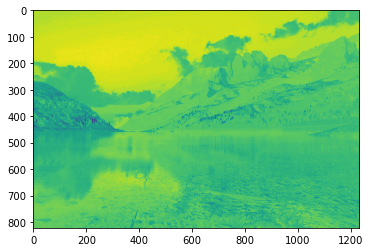

In [33]:
plt.imshow(_Cr)

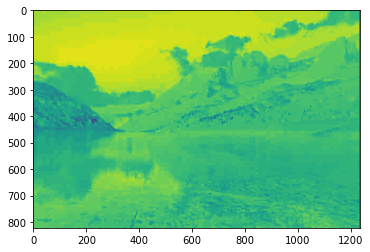

In [34]:
Cb_scaled = upscaleMatrix(Cb_joined, 2)
Cr_scaled = upscaleMatrix(Cr_joined, 2)
plt.imshow(Y_joined)
plt.imshow(Cb_scaled)
plt.imshow(Cr_scaled)

8. Juntamos as matrizes de Y, Cb e Cr

In [35]:
def joinMatrices(Y, Cb, Cr):
    Y_clipped = np.clip(Y, a_min=16, a_max=235)
    Cb_clipped = np.clip(Cb, a_min=16, a_max=235)
    Cr_clipped = np.clip(Cr, a_min=16, a_max=235)

    Cb_clipped = Cb_clipped[0:img_height, 0:img_width]
    Cr_clipped = Cr_clipped[0:img_height, 0:img_width]

    return cv2.merge((Y_clipped.astype(int), Cr_clipped.astype(int), Cb_clipped.astype(int)))

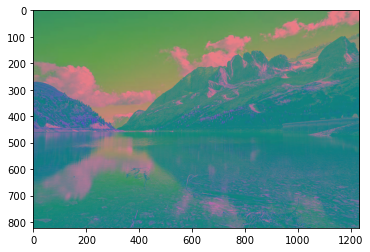

In [36]:
imgInYCbCr = joinMatrices(_Y, _Cb, _Cr)

myImg = joinMatrices(Y_joined, Cb_scaled, Cr_scaled)
plt.imshow(myImg)

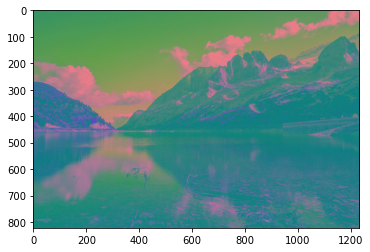

In [37]:
plt.imshow(imgInYCbCr)

9. E, finalmente, converter para RGB.

In [38]:
def convertYCbCrToRGB(imgInYCbCr):
    RGBimg = cv2.cvtColor(imgInYCbCr, cv2.COLOR_YCrCb2RGB)
    return RGBimg

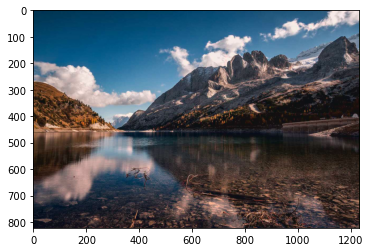

In [39]:
RGBImgOriginal = convertYCbCrToRGB(imgInYCbCr.astype('uint8'))
RGBImg = convertYCbCrToRGB(myImg.astype('uint8'))
cv2.imwrite('original.png', RGBImgOriginal)
cv2.imwrite('awesome.png', RGBImg)
plt.imshow(cv2.cvtColor(RGBImg, cv2.COLOR_RGB2BGR))